# Keyterm Parsing

In [1]:
import itertools
import networkx as nx
import nltk
import os
import numpy as np
import time
import json

import matplotlib.pyplot as plt
from nltk.corpus import words, gutenberg, reuters, webtext
import inflect
from nltk.corpus import wordnet as wn
import string

In [2]:
import spacy
from spacy.matcher import Matcher
from spacy.pipeline import EntityRuler
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

In [4]:
with open('sample.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
with open('lib/plural_to_singular.json', 'r') as f:
    plural_to_singular = json.load(f)

In [6]:
stopwords = nltk.corpus.stopwords.words('english')

In [7]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Entity Rules

Acroynms are defined as uppercase words of length greater than 1.

In [8]:
matcher = Matcher(nlp.vocab)
# Add match ID "HelloWorld" with no callback and one pattern
pattern = [{"IS_UPPER": True}]
matcher.add("acronym", None, pattern)

doc = nlp(text)
matches = matcher(doc)
acroynm_candidates = []
acroynm_set = set([])
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    if len(span.text) > 1 and span.text not in acroynm_set:
        acroynm_candidates.append(span)
        acroynm_set.add(span.text)
#     print(match_id, string_id, start, end, span.text)

In [9]:
acroynm_candidates

[API,
 CNTK,
 GPU,
 CPU,
 IDE,
 MLP,
 MSE,
 RMSE,
 MNIST,
 CNN,
 RNN,
 LSTM,
 MAE,
 H5,
 TF,
 GAN,
 MUNIT,
 BUT,
 JG,
 VGG16,
 SGD,
 PO,
 ACN,
 RSS]

In [10]:
def simplify(text):
    """Convert to lowercase, remove stopword, and singularize nouns"""
    tokens = nltk.word_tokenize(text.lower())
    simplified_tokens = []
    for word in tokens:
        if word not in stopwords and word not in string.punctuation:
            if word in plural_to_singular.keys():
                singular = plural_to_singular[word]
            else:
                singular = word
            simplified_tokens.append(singular)
    return simplified_tokens

def get_ent_id(text):
    return '-'.join(simplify(text))

In [11]:
entity_rules = []
entity_set = set([])
entity_ids = set([])
skiplabels = [ 'DATE','TIME', 'PERCENT', 'MONEY', 'QUANTITY','ORDINAL', 'CARDINAL']
i = 0
for ent in doc.ents:
    ent_id = get_ent_id(ent.text)
#     term = ent.text
    if ent.label_ not in skiplabels and ent.text not in entity_set:
        entity_rules.append((ent, ent_id))
        entity_set.add(ent.text)
        entity_ids.add(ent_id)

In [12]:
entity_rules

[(TensorFlow, 'tensorflow'),
 (Google, 'google'),
 (tf.keras API, 'tf.keras-api'),
 (Keras, 'keras'),
 (tf.keras, 'tf.keras'),
 (the tf.keras API, 'tf.keras-api'),
 (Stephen Harlan, 'stephen-harlan'),
 (API, 'api'),
 (python, 'python'),
 (algorithm, 'algorithm'),
 (Python, 'python'),
 (PyTorch, 'pytorch'),
 (Theano, 'theano'),
 (CNTK, 'cntk'),
 (TensorFlow 2, 'tensorflow-2'),
 (Keras API, 'keras-api'),
 (Keras Project Homepage, 'keras-project-homepage'),
 (Anaconda, 'anaconda'),
 (GPU, 'gpu'),
 (IDE, 'ides'),
 (the Sequential API, 'sequential-api'),
 (the Functional API, 'functional-api'),
 (Adam, 'adam'),
 (Sequential, 'sequential'),
 (MLP, 'mlp'),
 (Input, 'input'),
 (Model, 'model'),
 (Multilayer Perceptrons, 'multilayer-perceptrons'),
 (Convolutional Neural Networks, 'convolutional-neural-network'),
 (Recurrent Neural Networks, 'recurrent-neural-network'),
 (Multilayer Perceptron, 'multilayer-perceptron'),
 (Ionosphere, 'ionosphere'),
 (Pandas, 'pandas'),
 (LabelEncoder, 'labelenco

In [13]:
ent_id_list = list(entity_ids)
acronym_rules = {}
for cand in acroynm_candidates:
    cand_lower = cand.text.lower()

    for ent_id in ent_id_list:
        tokens = ent_id.split('-')
        
        if len(cand_lower) == len(tokens):
            match = all([cand_lower[i] == tokens[i][0] for i in range(len(cand_lower))])
        else:
            match = False
        
        if match:
            acronym_rules[cand_lower] = ent_id
            acronym_rules[cand_lower + 's'] = ent_id

In [14]:
acronym_rules

{'cnn': 'convolutional-neural-network',
 'cnns': 'convolutional-neural-network',
 'rnn': 'recurrent-neural-network',
 'rnns': 'recurrent-neural-network',
 'lstm': 'long-short-term-memory',
 'lstms': 'long-short-term-memory'}

In [15]:
entity_patterns = []

for chunk, ent_id in entity_rules:
    if chunk[0].text in ['the', 'The']:
        pattern = chunk[1:].text
    else:
        pattern = chunk.text
    
    if ent_id in acronym_rules.keys():
        pattern_id = acronym_rules[ent_id]
    else:
        pattern_id = ent_id
        
    entity_patterns.append({'label':'CUSTOM', 'pattern':pattern, 'id':pattern_id})

## Find Keywords

Extract phrases using TextRank with no a priori assumptions on word relevance.

In [16]:
def filter_for_tags(tagged, tags=['NN', 'NNS', 'JJ', 'NNP', 'NNPS']):
    """Apply syntactic filters based on POS tags."""
    return [item[0] for item in tagged if item[1] in tags]

In [17]:
def get_word_list(sentence):
    word_tokens = []
    for w in nltk.word_tokenize(sentence):
        if len(w) > 1 and w not in stopwords:
            if w in plural_to_singular.keys():
                word_tokens.append(plural_to_singular[w])
            else:
                word_tokens.append(w)
    tagged = nltk.pos_tag(word_tokens)
    word_list = filter_for_tags(tagged)
    return word_list

In [18]:
unique_word_set = set([])
edges = {}

for s in nltk.sent_tokenize(text):
    # tokenize the text using nltk
    word_list = get_word_list(s)
    word_list.sort()

    for word in word_list:
        if word not in unique_word_set:
            unique_word_set.add(word)

    for pair in itertools.combinations(word_list, 2):
        if pair in edges.keys():
            edges[pair] += 1
        else:
            edges[pair] = 1

In [19]:
gr = nx.Graph()  # initialize an undirected graph
gr.add_nodes_from(unique_word_set)

for key, weight in edges.items():
    gr.add_edge(key[0], key[1], weight=weight)

In [20]:
len(gr.nodes)

931

In [21]:
calculated_page_rank = nx.pagerank(gr.to_directed(), weight='weight')

In [22]:
all_keywords = sorted(calculated_page_rank, key=calculated_page_rank.get,reverse=True)

In [23]:
def plot_bar(sorted_arr, scores, n=50):
    labels = []
    width = []
    for kp in sorted_arr[:n]:
        print(kp, scores[kp])
        labels.append(' '.join(kp) if isinstance(kp, tuple) or isinstance(kp, list) else kp)
        width.append(scores[kp])
        
    plt.figure(figsize=(5,10))
    plt.barh(range(len(labels), 0,-1), width=width, tick_label=labels)
    plt.show()

model 0.036338784272843296
layer 0.0148471413818989
datum 0.013537451086478637
example 0.011819651660086848
function 0.010308514915031968
use 0.010106637154246024
dataset 0.009013769039589151
deep 0.008306332606608853
loss 0.008207474586738647
training 0.008097596477530451
API 0.0076655940537841815
tf.keras 0.007486063576446646
result 0.006856158004725511
learning 0.006734475561395977
tutorial 0.0066035815200281515
TensorFlow 0.006539060156805839
input 0.00634647455600162
image 0.00631176276191179
time 0.005994112465725461
case 0.005687816287246497
Keras 0.005680319163852842
network 0.005573948379596697
number 0.005500359003426558
MLP 0.005417918365669719
output 0.005305468191336901
import 0.005006722585640221
problem 0.004753565246146639
value 0.004610075766771956
classification 0.00459076631933306
new 0.004566293664656864
line 0.004535135896603563
accuracy 0.004458031868773382
code 0.004193359674377352
class 0.004189319510941384
print 0.004096616357477717
prediction 0.004062339192506

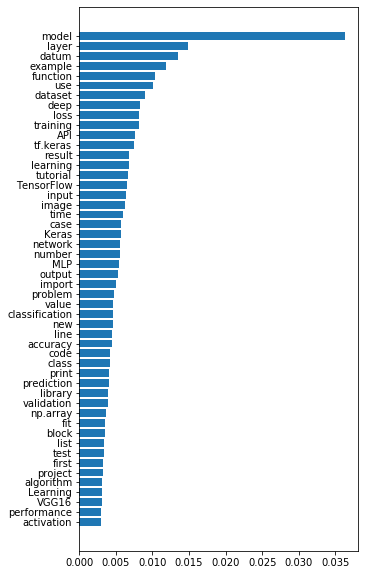

In [24]:
plot_bar(all_keywords, calculated_page_rank, n=50)

In [25]:
np.sum([calculated_page_rank[kp] for kp in all_keywords])

0.9999999999999998

## Find Phrases

In [26]:
word_tokens = nltk.word_tokenize(text)
tagged = nltk.pos_tag(word_tokens)
textlist = [x[0] for x in tagged]
keywords = all_keywords[:len(all_keywords)//10]
phrase_freq = {}

In [27]:
def get_phrases(textlist, keywords, k=2):
    # take keyphrases with multiple words into consideration as done in the
    # paper - if two words are adjacent in the text and are selected as
    # keywords, join them together
    modified_key_phrases = set([])
    # keeps track of individual keywords that have been joined to form a keyphrase
    i = k-1
    while i < len(textlist):
        consecutive = tuple(textlist[i-k+1:i+1])
        if all([word in keywords for word in consecutive]):
            modified_key_phrases.add(consecutive)
            if consecutive in phrase_freq.keys():
                phrase_freq[consecutive] += 1
            else:
                phrase_freq[consecutive] = 1
        i += 1
        
    keyword_freq = {}
    for word in textlist:
        if word in keywords:
            if word in keyword_freq.keys():
                keyword_freq[word] += 1
            else:
                keyword_freq[word] = 1
                
    return list(modified_key_phrases), keyword_freq

In [28]:
keyphrases, freq = get_phrases(textlist, keywords, k=2)

In [29]:
keyphrases[:20]

[('training', 'epochs'),
 ('TensorFlow', 'deep'),
 ('classification', 'problem'),
 ('MLP', 'model'),
 ('new', 'layer'),
 ('deep', 'neural'),
 ('neural', 'network'),
 ('model', 'API'),
 ('use', 'code'),
 ('model', 'training'),
 ('block', 'number'),
 ('Hi', 'Jason'),
 ('MLP', 'network'),
 ('classification', 'dataset'),
 ('CNN', 'example'),
 ('learning', 'library'),
 ('input', 'layer'),
 ('image', 'classification'),
 ('classification', 'prediction'),
 ('loss', 'line')]

In [30]:
phrase_scores = {}
for p in keyphrases:
#     print(p)
    phrase_scores[p] = np.power(np.prod([phrase_freq[p] / freq[w] for w in p]), 1/len(p))

In [31]:
sorted_phrases = sorted(phrase_scores, key=phrase_scores.get, reverse=True)

('deep', 'learning') 0.6933752452815364
('Deep', 'Learning') 0.6324555320336759
('neural', 'network') 0.5833333333333334
('Hi', 'Jason') 0.5720775535473553
('binary', 'classification') 0.5400617248673216
('np', 'import') 0.5
('activation', 'function') 0.4383972994809528
('Test', 'Accuracy') 0.4
('small', 'neural') 0.375
('training', 'process') 0.30123203803835463
('tf.keras', 'API') 0.282494169258455
('test', 'dataset') 0.28097574347450816
('classification', 'accuracy') 0.25197631533948484
('validation', 'dataset') 0.24779731389167603
('training', 'dataset') 0.23693955110363693
('accuracy', 'evaluation') 0.21821789023599236
('line', 'plot') 0.21081851067789195
('loss', 'function') 0.21010507881568247
('learning', 'algorithm') 0.2090605025017727
('output', 'layer') 0.20207259421636903
('classification', 'problem') 0.20025046972870356
('learning', 'library') 0.15724272550828775
('block', 'line') 0.14907119849998599
('code', 'block') 0.14907119849998599
('example', 'first') 0.140193038523

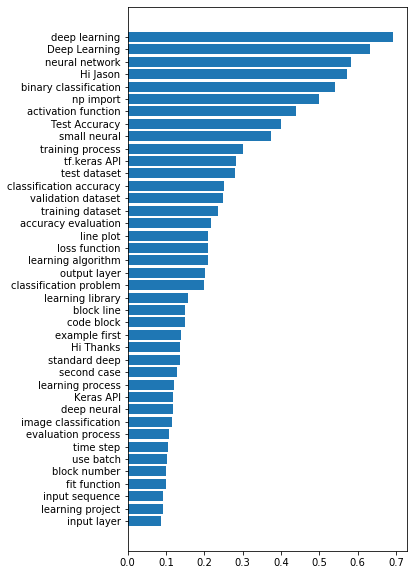

In [32]:
plot_bar(sorted_phrases, phrase_scores, n=40)

In [33]:
def get_top_half(sorted_list, scores):
    score_sum = sum([scores[k] for k in sorted_list])
    results = []
    s = 0
    i = 0
    while s < 0.5:
        norm_score = scores[sorted_list[i]] / score_sum
        s += norm_score
        results.append(sorted_list[i])
        i += 1
    return results

In [34]:
top_phrases = get_top_half(sorted_phrases, phrase_scores)

In [35]:
top_phrases

[('deep', 'learning'),
 ('Deep', 'Learning'),
 ('neural', 'network'),
 ('Hi', 'Jason'),
 ('binary', 'classification'),
 ('np', 'import'),
 ('activation', 'function'),
 ('Test', 'Accuracy'),
 ('small', 'neural'),
 ('training', 'process'),
 ('tf.keras', 'API'),
 ('test', 'dataset'),
 ('classification', 'accuracy'),
 ('validation', 'dataset')]

### Add Phrases to Entity Rules

In [36]:
for phrase in top_phrases:
    pattern = ' '.join(phrase)
    pattern_id = get_ent_id(pattern)
    entity_patterns.append({'label':'CUSTOM', 'pattern': pattern, 'id':pattern_id})

In [37]:
entity_patterns

[{'label': 'CUSTOM', 'pattern': 'TensorFlow', 'id': 'tensorflow'},
 {'label': 'CUSTOM', 'pattern': 'Google', 'id': 'google'},
 {'label': 'CUSTOM', 'pattern': 'tf.keras API', 'id': 'tf.keras-api'},
 {'label': 'CUSTOM', 'pattern': 'Keras', 'id': 'keras'},
 {'label': 'CUSTOM', 'pattern': 'tf.keras', 'id': 'tf.keras'},
 {'label': 'CUSTOM', 'pattern': 'tf.keras API', 'id': 'tf.keras-api'},
 {'label': 'CUSTOM', 'pattern': 'Stephen Harlan', 'id': 'stephen-harlan'},
 {'label': 'CUSTOM', 'pattern': 'API', 'id': 'api'},
 {'label': 'CUSTOM', 'pattern': 'python', 'id': 'python'},
 {'label': 'CUSTOM', 'pattern': 'algorithm', 'id': 'algorithm'},
 {'label': 'CUSTOM', 'pattern': 'Python', 'id': 'python'},
 {'label': 'CUSTOM', 'pattern': 'PyTorch', 'id': 'pytorch'},
 {'label': 'CUSTOM', 'pattern': 'Theano', 'id': 'theano'},
 {'label': 'CUSTOM', 'pattern': 'CNTK', 'id': 'cntk'},
 {'label': 'CUSTOM', 'pattern': 'TensorFlow 2', 'id': 'tensorflow-2'},
 {'label': 'CUSTOM', 'pattern': 'Keras API', 'id': 'ker

## Dependency TextRank

In [38]:
ruler = EntityRuler(nlp)
ruler.add_patterns(entity_patterns)
nlp.add_pipe(ruler, before='ner')

modified_doc = nlp(text)

In [39]:
# for ent in modified_doc.ents:
#     if ent.label_ not in skiplabels:
#         print(ent.text, ent.label_, ent.ent_id_)

In [40]:
with modified_doc.retokenize() as retokenizer:
    for ent in modified_doc.ents:
        retokenizer.merge(ent)

In [41]:
# displacy.render(modified_doc, style="ent")

In [42]:
displacy.render(modified_doc[200:300], style="dep")

In [43]:
sentences = list(modified_doc.sents)

In [72]:
edges = {}

for s in sentences:
#     unique_nouns = set([])
    noun_list = []
    for token in s:
        if token.pos_ in ['NOUN', 'PROPN', 'X']:
            if token.ent_id_ != '':
                noun = token.ent_id_
            else:
                noun = token.text
            if noun not in noun_list:
                noun_list.append(noun)
#     print(noun_list)

    for pair in itertools.combinations(noun_list, 2):
        if pair in edges.keys():
            edges[pair] += 1
        else:
            edges[pair] = 1

In [73]:
gr = nx.DiGraph()  # initialize an undirected graph
gr.add_nodes_from(unique_word_set)

for key, weight in edges.items():
    gr.add_edge(key[0], key[1], weight=weight)

In [74]:
len(gr.nodes)

713

In [75]:
calculated_page_rank = nx.pagerank(gr, weight='weight')

In [76]:
all_keywords = sorted(calculated_page_rank, key=calculated_page_rank.get,reverse=True)

model 0.03561540243062491
data 0.020135776492023187
training 0.014748902892800559
layer 0.014317683444562464
output 0.011495898766899834
loss 0.01060854870271256
models 0.010555890098938196
validation 0.008903351613973645
input 0.008794335459307962
function 0.008565367412526852
dataset 0.0080074998002717
evaluation 0.007778499425863449
layers 0.007228694940129606
values 0.007226612579768098
error 0.0070521665066436675
network 0.00691379667035954
test 0.006415126969918806
api 0.006245973612801958
class 0.006228926588207004
time 0.005868985390003338
example 0.00579576913429467
use 0.005745184489874334
activation-function 0.005355218261038857
epoch 0.0053413008005594375
deep-learning 0.005319703433681108
accuracy 0.005313860539229218
inputs 0.0053046824566211175
number 0.005291718876613418
parameters 0.005247441793591326
predictions 0.005240654494024244
line 0.005230890123961653
value 0.005158378786003866
code 0.005128613394066937
tf.keras 0.005055965695947579
image 0.004769598876221666
p

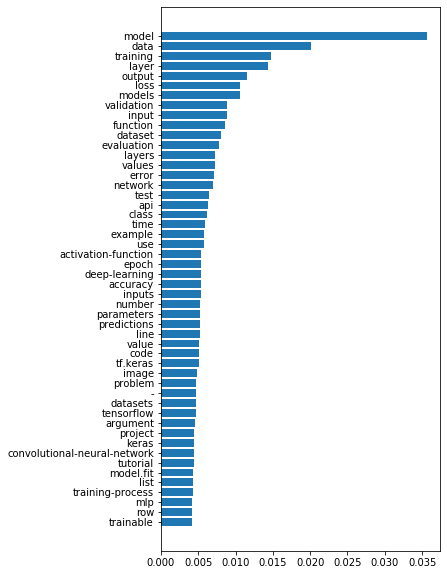

In [77]:
plot_bar(all_keywords, calculated_page_rank)